In [ ]:
!curl https://www.kaggle.com/datasets/Cornell-University/arxiv/download?datasetVersionNumber=118

In [ ]:
!unzip arxiv-metadata-oai-snapshot.json.zip

In [ ]:
!pip install python-louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

First we explored the python-louvain implementation of the Louvain algorithm, using the *Les Misérables* character interaction graph as a toy example.

In [ ]:
M = nx.les_miserables_graph()

In [ ]:
M_partition = community_louvain.best_partition(M)
M_comm_graph = community_louvain.induced_graph(M_partition, M)

In the below graph, each novel character is coloured according to their community membership as calculated by the Louvain algorithm.

<ipython-input-54-498a8ad80262>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(M_partition.values()) + 1)


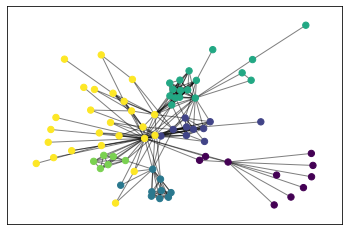

In [ ]:
pos = nx.spring_layout(M, seed=1000)
cmap = cm.get_cmap('viridis', max(M_partition.values()) + 1)
nx.draw_networkx_nodes(M, pos, M_partition.keys(), node_size = 40,
                       cmap = cmap, node_color = list(M_partition.values()))
nx.draw_networkx_edges(M, pos, alpha=0.5)
plt.show()

And this simpler graph shows the relationship between communities. Note that each community self-links, as individuals within the community tend to link to one another.

<ipython-input-57-952a790ba0cb>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_comm = cm.get_cmap('viridis', 6)
/usr/local/lib/python3.9/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


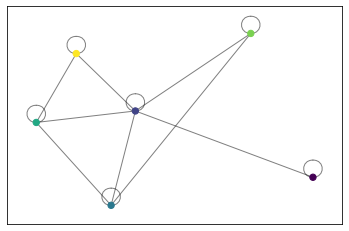

In [ ]:
pos_comm = nx.spring_layout(M_comm_graph, seed=1000)
cmap_comm = cm.get_cmap('viridis', 6)
nx.draw_networkx_nodes(M_comm_graph, pos_comm, node_size = 40,
                       cmap = cmap_comm, node_color = list(cmap_comm.colors))
nx.draw_networkx_edges(M_comm_graph, pos_comm, alpha = 0.5)
plt.show()

In [ ]:
arxiv = []

with open("/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json", "rb") as file:
  for line in file:
    line = json.loads(line)
    arxiv.append(line.get('authors_parsed'))



In [ ]:
authors = {}

`get_authors` is a function to parse out the first author of each paper, their published name, and the published names of all their co-authors, stored as a dictionary of dictionaries. The inner dictionary keeps track of the number of shared publications between that pair of authors.




In [ ]:
#create a dictionary of dictionaries, first level dict is first authors, with sub-dicts
#containing their co-authors and number of co-authorships

def get_authors(entry):
  first_author = ""
  coauthor_list = []
  authorship_length = len(arxiv[entry])
  name_length = len(arxiv[entry][0])
  #get first author
  for i in range(name_length):
    name = arxiv[entry][0][i]
    if name is not None:
      first_author += name
  #get co-authors
  for i in range(1, authorship_length):
    coauthor_name = ""
    coauthor_name_length = len(arxiv[entry][i])
    for j in range(coauthor_name_length):
      name = arxiv[entry][i][j]
      if name is not None:
        coauthor_name += name
    coauthor_list.append(coauthor_name)

  #populate dicts
  if first_author not in authors:
    authors[first_author] = {}
    for i in coauthor_list:
      authors[first_author][i] = {}
      authors[first_author][i]['weight'] = 1
  else:
    for i in coauthor_list:
      if i not in authors[first_author]:
        authors[first_author][i] = {}
        authors[first_author][i]['weight'] = 1
      else:
        authors[first_author][i]['weight'] += 1


In [ ]:
for i in range(len(arxiv)):
  get_authors(i)

This dictionary-of-dictionaries structure tracking co-authorship is written as a JSON file for storage.

In [ ]:
with open ("/content/drive/MyDrive/authors_all.json", "w") as outfile:
  json.dump(authors, outfile)

In [ ]:
G = nx.from_dict_of_dicts(authors)

We also write the co-authorship tracking structure as a set of nested tuples for use with our developing code.

In [ ]:
with open ("/content/drive/MyDrive/authors_tuples", "w") as outfile:  
  for nodes in G:
    print((G.edges(nodes, data='weight')), file = outfile)

We can check the co-authorship statistics for a given author. While the `authors` dictionary of dictionaries is primarily keyed to the first authors, the graph structure `G` includes links where a given author is not the primary author of a manuscript.

In [ ]:
authors['BalázsC.']

{'BergerE. L.': {'weight': 1},
 'NadolskyP. M.': {'weight': 1},
 'YuanC. -P.': {'weight': 1},
 'SahuN.': {'weight': 1},
 'MazumdarA.': {'weight': 1}}

In [ ]:
G['BalázsC.']

AtlasView({'BergerE. L.': {'weight': 1}, 'NadolskyP. M.': {'weight': 1}, 'YuanC. -P.': {'weight': 1}, 'SahuN.': {'weight': 1}, 'MazumdarA.': {'weight': 1}, 'BrooijmansG.': {'weight': 1}, 'AbramowiczH.': {'weight': 1}, 'AssamaganK. A.': {'weight': 1}, 'SkandsP.': {'weight': 1}})

We can also produce a subgraph centered on that given author, showing all of his immediate co-authors (scientists with whom he has directly co-authored papers). This can be extended to second and third degree relationships by adjusting the radius variable, but the graph quickly becomes too dense to read.

{('BalázsC.',
  'BergerE. L.'): Text(-0.4693988081393103, 0.024996400778700256, '1'),
 ('BalázsC.',
  'NadolskyP. M.'): Text(-0.1370308904894936, 0.3581372116627777, '1'),
 ('BalázsC.',
  'YuanC. -P.'): Text(-0.11094655038322022, 0.2173421059788619, '1'),
 ('BalázsC.', 'SahuN.'): Text(0.4848414200908016, 0.2844129826376974, '1'),
 ('BalázsC.',
  'MazumdarA.'): Text(0.5067355229032615, -0.23314000046331698, '1'),
 ('BalázsC.',
  'BrooijmansG.'): Text(-0.21432925362674482, -0.168010246534089, '1'),
 ('BalázsC.',
  'AbramowiczH.'): Text(0.11658979145012499, -0.5024753040553882, '1'),
 ('BalázsC.',
  'AssamaganK. A.'): Text(0.2023130881790097, 0.2755351728401596, '1'),
 ('BalázsC.',
  'SkandsP.'): Text(-0.1339647850989108, -0.39933846676434753, '1'),
 ('SkandsP.',
  'BrooijmansG.'): Text(-0.40949642244703505, -0.5317136773187001, '2'),
 ('SkandsP.',
  'AbramowiczH.'): Text(-0.07857737737016525, -0.8661787348399993, '1'),
 ('BrooijmansG.',
  'YuanC. -P.'): Text(-0.38647818773134446, 0.08496

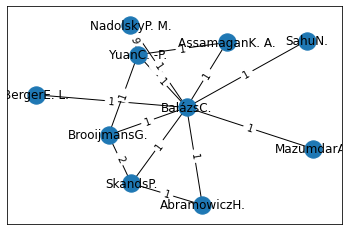

In [ ]:
balazs = nx.ego_graph(G, 'BalázsC.', radius=1)
pos = nx.spring_layout(balazs, seed=1000000)
nx.draw_networkx_nodes(balazs, pos)
nx.draw_networkx_edges(balazs, pos)
edge_weights = nx.get_edge_attributes(balazs,'weight')
nx.draw_networkx_labels(balazs, pos)
nx.draw_networkx_edge_labels(balazs, pos, edge_labels=edge_weights)

Using the `python-louvain` library, we can produce a community graph of our co-authorship network. In Google Colab, this takes approximately 49 minutes.

In [ ]:
partition = community_louvain.best_partition(G)

In [ ]:
with open ("/content/drive/MyDrive/partition.json", "w") as outfile:
  json.dump(partition, outfile)

The average unweighted degree of this undirected graph is approximately 4.8.

In [ ]:
print("The average degree of G is ", round(sum(dict(G.degree()).values())/float(len(G)),4))

The average degree of G is  4.8003


The entire graph of authors includes 1,766,211 authors as nodes, 4,239,171 co-authorships as edges, and is not a connected graph, meaning that there are subgraphs of authors with no connections between them.

In [ ]:
print("The total number of authors is: ", nx.number_of_nodes(G))
print("The total number of co-authorships is: ", nx.number_of_edges(G))
print("Is the network of authors connected?", nx.is_connected(G))

The total number of nodes is:  1766211
The total number of edges is:  4239171
Is the network connected? False


We can similarly check statistics on the community graph produced by the Louvain algorithm. There are 116,741 communities of co-authors, with 67,390 co-authorship edges between those communities. As expected, the community graph is also not connected. Those subgraphs of authors in the complete graph cannot possibly form communities with other scientists with whom they've never co-authored a paper directly or indirectly.

In [ ]:
comm_graph = community_louvain.induced_graph(partition, G)

In [ ]:
print("The total number of communities is ", nx.number_of_nodes(comm_graph))
print("The total number of inter- and intracommunity co-authorships is ", nx.number_of_edges(comm_graph))
print("Is the network of communities connected?", nx.is_connected(comm_graph))

The total number of communities is  116734
The total number of inter- and intracommunity co-authorships is  67548
Is the network of communities connected? False
